In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef,
)


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error,mean_squared_error,r2_score


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv("/content/water_potability.csv")

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


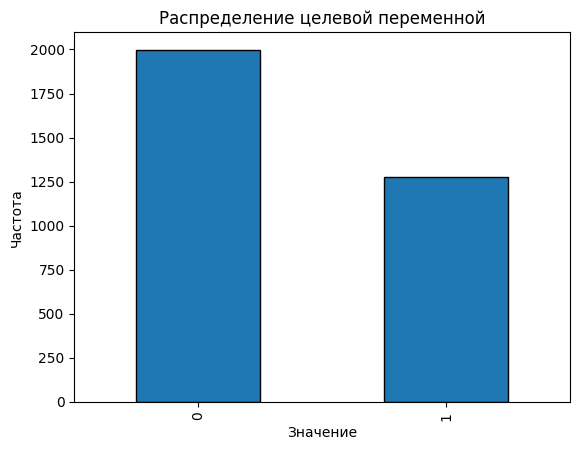

In [ ]:
import matplotlib.pyplot as plt

df['Potability'].value_counts().plot(kind='bar', edgecolor='black')

plt.title('Распределение целевой переменной')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()


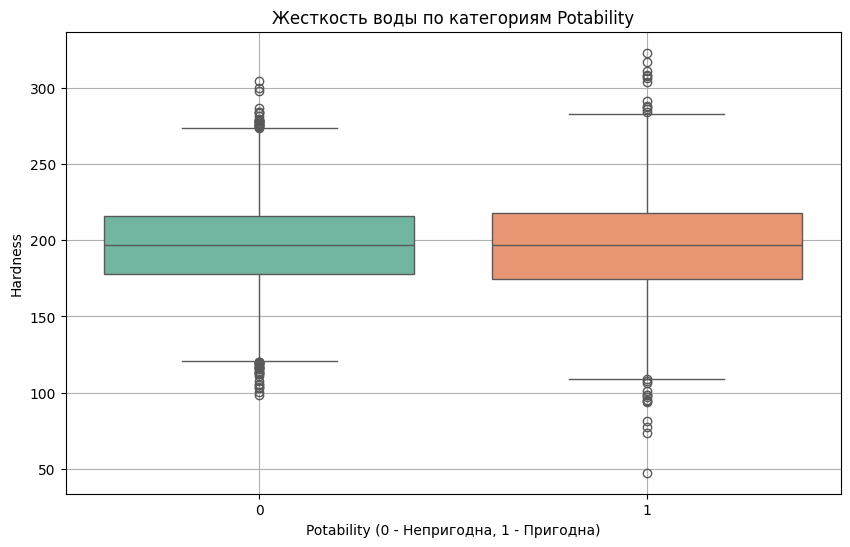

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Potability', y='Hardness', data=df, palette='Set2')
plt.title('Жесткость воды по категориям Potability')
plt.xlabel('Potability (0 - Непригодна, 1 - Пригодна)')
plt.ylabel('Hardness')
plt.grid(True)
plt.show()

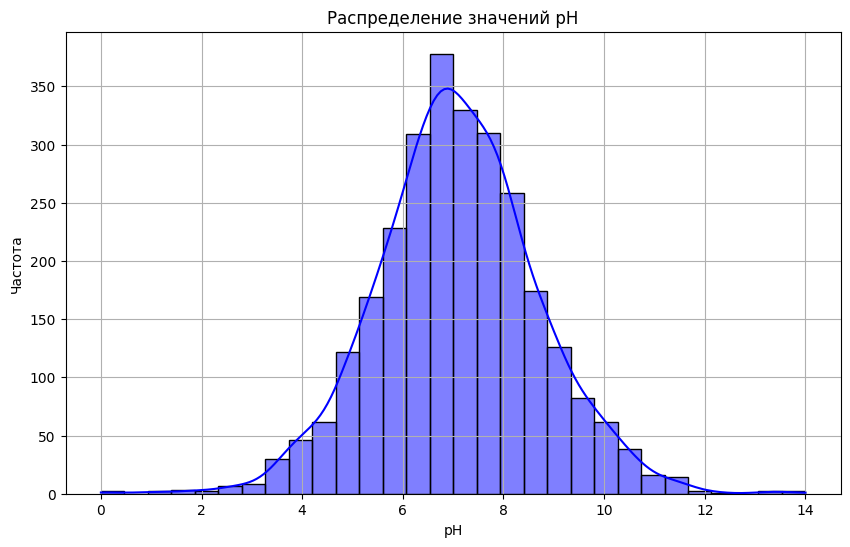

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ph'], bins=30, kde=True, color='blue')
plt.title('Распределение значений pH')
plt.xlabel('pH')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

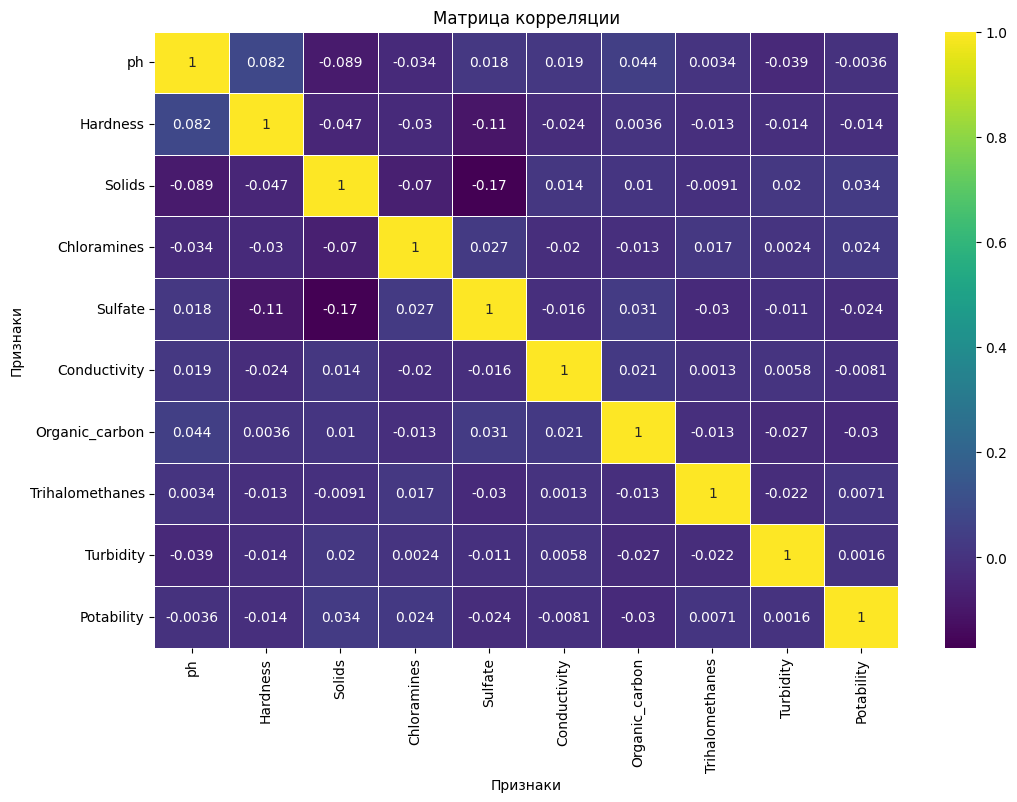

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis', linewidths=0.4)

plt.title('Матрица корреляции')
plt.xlabel('Признаки')
plt.ylabel('Признаки')

plt.show()


In [ ]:
df_one = df[df['Potability']==1].copy()
df_zero_downsampled = df[df['Potability']==0].sample(1250, random_state=42).copy()

In [ ]:
new_df = pd.concat([df_one, df_zero_downsampled])

new_df.shape

(2528, 10)

In [ ]:
X = new_df.drop(['Potability'], axis=1)
y = new_df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, )

In [ ]:
tree_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),

])

transformed_data = tree_pipeline.fit_transform(X_train,y_train)


In [ ]:
dt_pipe = Pipeline([
    ('preprocessor', tree_pipeline),
    ('dt', DecisionTreeClassifier(random_state=42))
])

dt_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [ ]:
params = {
    'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'dt__criterion': ['gini', 'entropy'],
}

dt_grid_search = GridSearchCV(dt_pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=-1, verbose=1)

dt_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median'))])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='roc_auc', verbose=1)

In [ ]:
print('Best params', dt_grid_search.best_params_)
print('Best score', dt_grid_search.best_score_)

Best params {'dt__criterion': 'gini', 'dt__max_depth': 7}
Best score 0.6182019798210546


In [ ]:
params = {
    'dt__max_depth': range(1, 20), # 20
    'dt__criterion': ['gini', 'entropy'],
}

dt_random_search = RandomizedSearchCV(dt_pipe, param_distributions=params, scoring='roc_auc', cv=10, n_jobs=-1, verbose=1, n_iter=15)

dt_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(strategy='median'))])),
                                             ('dt',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__max_depth': range(1, 20)},
                   scoring='roc_auc', verbose=1)

In [ ]:
print('Best params', dt_random_search.best_params_)
print('Best score', dt_random_search.best_score_)

Best params {'dt__max_depth': 7, 'dt__criterion': 'entropy'}
Best score 0.6093671235484484


In [ ]:
rf_pipe = Pipeline([
    ('preprocessor', tree_pipeline),
    ('rf', RandomForestClassifier(random_state=42))
])

In [ ]:
params = {
    'rf__n_estimators': range(50, 250),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [10, 20, 30]
}

rf_random_search = RandomizedSearchCV(rf_pipe, param_distributions=params, scoring='roc_auc', cv=10, n_jobs=-1, verbose=1, n_iter=15)

rf_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(strategy='median'))])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'rf__max_depth': [10, 20, 30],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__n_estimators': range(50, 250)},
                   scoring='roc_auc', verbose=1)

In [ ]:
print('Best params', rf_random_search.best_params_)
print('Best score', rf_random_search.best_score_)

Best params {'rf__n_estimators': 228, 'rf__max_features': 'sqrt', 'rf__max_depth': 30}
Best score 0.6727463354273748


In [ ]:
best_rf = rf_random_search.best_estimator_

roc_df = pd.DataFrame(
    {
        'y_label': best_rf.predict(X_test),
        'y_custom_label': best_rf.predict_proba(X_test)[:, 1] > 0.4,
        'y_pred': best_rf.predict_proba(X_test)[:, 1]
    }
)

px.scatter(roc_df, y='y_pred', color='y_custom_label')

In [ ]:
xgb_pipe = Pipeline([
    ('preprocessor', tree_pipeline),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [ ]:
xgb_params = {
    'xgb__n_estimators': range(50, 200, 50),
    'xgb__max_depth': range(3, 10, 2),
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

In [ ]:
xgb_random_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=xgb_params,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1,
    n_iter=15
)

xgb_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(strategy='median'))])),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            f...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.7, 0.8,
                                                                  0.9],
                                        'xgb__learning_rate': [0.01, 0.1, 0.2],
                                        'xgb__max_depth': range(3, 10, 2),
                                        'xgb__n_estimators': range(50, 200, 50),
                                        'xgb__subsample': [0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=1)

In [ ]:
y_pred_proba = best_rf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# get the best threshold based on Youden's J statistic
J = tpr - fpr
j_ix = np.argmax(J)
best_threshold = thresholds[j_ix]

best_threshold

0.5307017543859649

In [ ]:
best_xgb = xgb_random_search.best_estimator_

roc_df = pd.DataFrame({
    'y_label': best_xgb.predict(X_test),
    'y_custom_label': best_xgb.predict_proba(X_test)[:, 1] > 0.53,
    'y_pred': best_xgb.predict_proba(X_test)[:, 1]
})

# Визуализация
fig = px.scatter(roc_df, x='y_label', y='y_pred', color='y_custom_label')
fig.show()

print(f"Лучшие параметры для XGBoost: {xgb_random_search.best_params_}")
print(f"Лучшая кросс-валидационная ROC-AUC: {xgb_random_search.best_score_:.4f}")

Лучшие параметры для XGBoost: {'xgb__subsample': 0.8, 'xgb__n_estimators': 150, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.9}
Лучшая кросс-валидационная ROC-AUC: 0.6711


In [ ]:
y_pred = best_xgb.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy_best)
print("Precision Score:", precision)
print("Recall: ",recall )
print("F1 score: ", f1)
print("Confusion Matrix:",conf_matrix)

Test Accuracy: 0.650197628458498
Precision Score: 0.6573705179282868
Recall:  0.64453125
F1 score:  0.6508875739644971
Confusion Matrix: [[164  86]
 [ 91 165]]


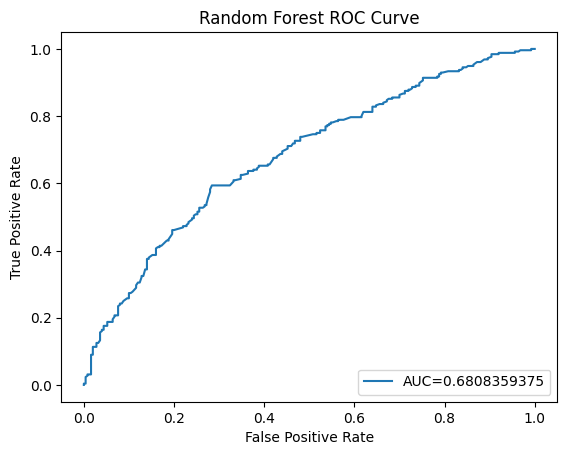

In [ ]:
best_rf = rf_random_search.best_estimator_

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

In [ ]:
y_pred_1 = best_rf.predict(X_test)
accuracy_best1 = accuracy_score(y_test, y_pred_1)
conf_matrix1 = confusion_matrix(y_test, y_pred_1)
precision1 = precision_score(y_test, y_pred_1)
recall1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

print("Test Accuracy:", accuracy_best1)
print("Precision Score:", precision1)
print("Recall: ",recall1 )
print("F1 score: ", f1_1)
print("Confusion Matrix:",conf_matrix1)

Test Accuracy: 0.6304347826086957
Precision Score: 0.632183908045977
Recall:  0.64453125
F1 score:  0.6382978723404256
Confusion Matrix: [[154  96]
 [ 91 165]]


In [ ]:
import pickle

file1 = open("water_pred_model.pkl", 'wb')

pickle.dump(best_xgb, file1)
file1.close()

In [ ]:
import pickle

file2 = open("water_pred_model.pkl", 'rb')
model = pickle.load(file2)